In [3]:
import os
import sys

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset
from utils import export, show_side_by_side, show_features
from statistics import Statistics
from prob_opt import PredictStructs

In [4]:
data_dir = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12'
ifp_dir = 'ifp/ifp2'
mcss_dir = 'mcss/mcss7'

chembl_file = 'best_affinity.txt'

stats_prots = ['SIGMA1','5HT2B','AR','B1AR']#,'B1AR']
pred_prots = ['BRAF']

features = {
    'mcss':[],
    'hbond':[2,3],
    #'sb2':[1],
    #'sb':[4],
    'pipi':[6]#,
    #'picat':[7,8],
    #'contact':[11]
}

In [5]:
all_prots = stats_prots + pred_prots
all_data = Dataset(all_prots, data_dir, glide_dir, ifp_dir, mcss_dir)

# load in statistics ligands
ligands = {p: prot.lm.pdb for p,prot in all_data.proteins.items()}# if p in stats_prots}

all_data.load(ligands, load_fp=True, load_mcss=True)

#all_data = Dataset(data, load_prots)

#all_data.load_docking(glide_dir, ifp_dir, mcss_dir, structs=struct_dict,
#                      load_fp=True, load_crystal=False, load_chembl=False, load_mcss=True)

#stats = Statistics(all_data, load_prots, 20, 100, features, 0.25)

#for f_name in features.keys():
#    print f_name, stats.evidence.std[f_name]
#    stats.show_stats(f_name, raw=False, smoothed=True)
#    #stats.show_stats_by_pair(f_name, raw=False, smoothed=True)

[Errno 2] No such file or directory: '/scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4H58_lig-to-1UWH.fp'
/scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4H58_lig-to-1UWH.fp fp not found
check /scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4H58_lig-to-1UWH.fp
missing fp? /scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4H58_lig-to-1UWH.fp
[Errno 2] No such file or directory: '/scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4JVG_lig-to-1UWH.fp'
/scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4JVG_lig-to-1UWH.fp fp not found
check /scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4JVG_lig-to-1UWH.fp
missing fp? /scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4JVG_lig-to-1UWH.fp
[Errno 2] No such file or directory: '/scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4KSP_lig-to-1UWH.fp'
/scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4KSP_lig-to-1UWH.fp fp not found
check /scratch/PI/rondror/jbelk/method/data/BRAF/ifp/ifp2/4KSP_lig-to-1UWH.fp
missing fp

In [6]:
num_stats_ligs = 25
num_stats_poses = 25
smooth = 0.02
normalize = True
stats = Statistics(all_data, ['BRAF'], num_stats_ligs, num_stats_poses, features, smooth, False)

mcss


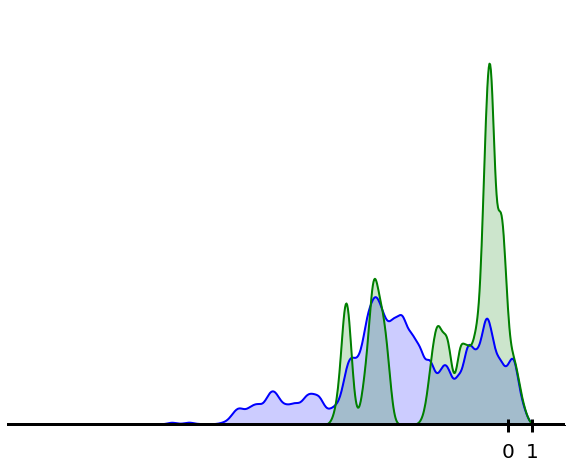

1UWH_lig 2FB8_lig
1UWH_lig 3C4C_lig
1UWH_lig 3D4Q_lig
1UWH_lig 3IDP_lig
1UWH_lig 3II5_lig
error
1UWH_lig 3PPJ_lig
1UWH_lig 3PPK_lig
1UWH_lig 3PRF_lig
1UWH_lig 3PRI_lig
1UWH_lig 3PSB_lig
1UWH_lig 3PSD_lig
1UWH_lig 3Q4C_lig
1UWH_lig 3Q96_lig


/share/PI/rondror/software/miniconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/share/PI/rondror/software/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


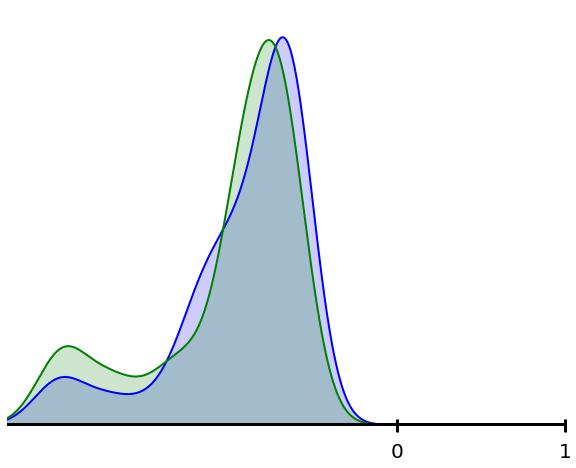

1UWH_lig 3SKC_lig
1UWH_lig 3TV4_lig
1UWH_lig 3TV6_lig
1UWH_lig 4DBN_lig
1UWH_lig 4E26_lig
1UWH_lig 4E4X_lig
1UWH_lig 4EHE_lig
1UWH_lig 4EHG_lig
error
1UWH_lig 4FC0_lig
1UWH_lig 4G9C_lig


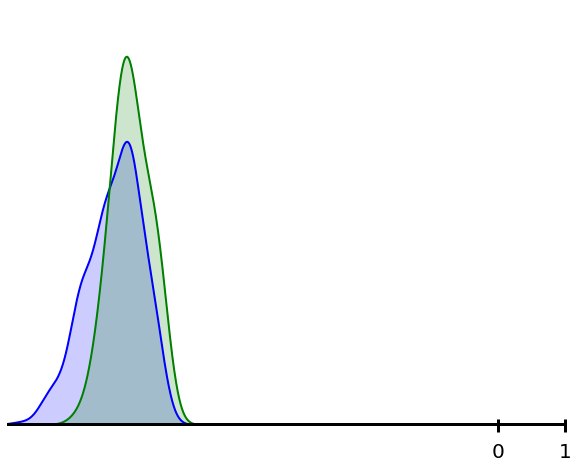

1UWH_lig 4G9R_lig
2FB8_lig 3C4C_lig
2FB8_lig 3D4Q_lig
error
2FB8_lig 3IDP_lig
2FB8_lig 3II5_lig
2FB8_lig 3PPJ_lig
2FB8_lig 3PPK_lig
2FB8_lig 3PRF_lig
2FB8_lig 3PRI_lig
2FB8_lig 3PSB_lig
2FB8_lig 3PSD_lig
2FB8_lig 3Q4C_lig
2FB8_lig 3Q96_lig
2FB8_lig 3SKC_lig
2FB8_lig 3TV4_lig
2FB8_lig 3TV6_lig
2FB8_lig 4DBN_lig
2FB8_lig 4E26_lig
2FB8_lig 4E4X_lig
2FB8_lig 4EHE_lig
2FB8_lig 4EHG_lig
2FB8_lig 4FC0_lig
2FB8_lig 4G9C_lig
2FB8_lig 4G9R_lig
3C4C_lig 3D4Q_lig
3C4C_lig 3IDP_lig
3C4C_lig 3II5_lig
3C4C_lig 3PPJ_lig
3C4C_lig 3PPK_lig
3C4C_lig 3PRF_lig
3C4C_lig 3PRI_lig
3C4C_lig 3PSB_lig
3C4C_lig 3PSD_lig
3C4C_lig 3Q4C_lig
3C4C_lig 3Q96_lig
3C4C_lig 3SKC_lig
error
3C4C_lig 3TV4_lig


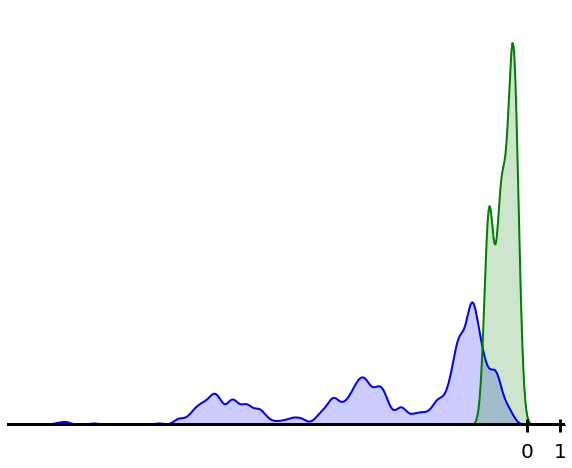

3C4C_lig 3TV6_lig


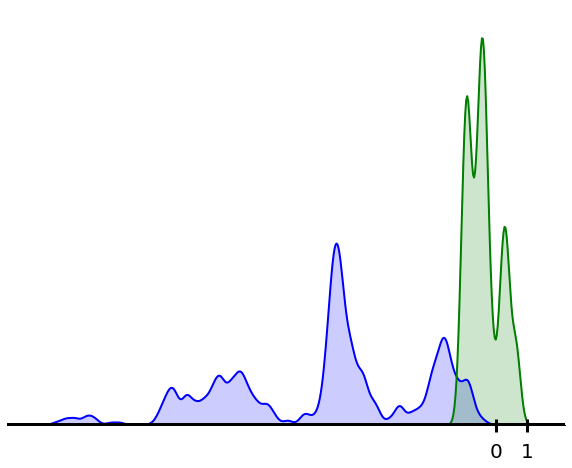

3C4C_lig 4DBN_lig
3C4C_lig 4E26_lig
3C4C_lig 4E4X_lig
error
3C4C_lig 4EHE_lig


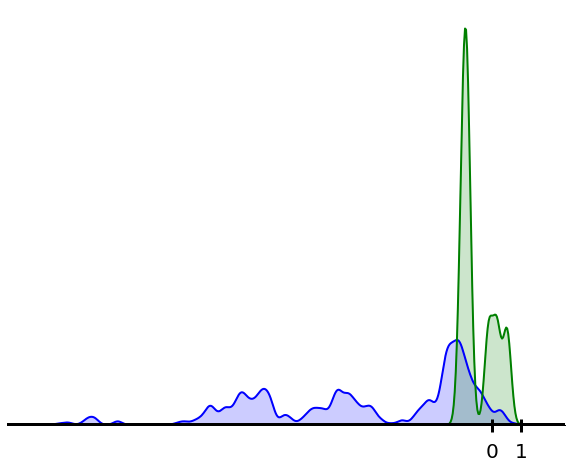

3C4C_lig 4EHG_lig
error
3C4C_lig 4FC0_lig
3C4C_lig 4G9C_lig


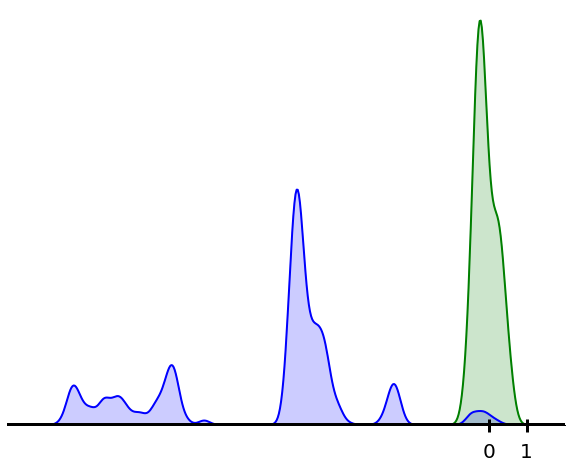

3C4C_lig 4G9R_lig
3D4Q_lig 3IDP_lig
3D4Q_lig 3II5_lig
error
3D4Q_lig 3PPJ_lig
3D4Q_lig 3PPK_lig
3D4Q_lig 3PRF_lig
3D4Q_lig 3PRI_lig
3D4Q_lig 3PSB_lig
3D4Q_lig 3PSD_lig
3D4Q_lig 3Q4C_lig
3D4Q_lig 3Q96_lig
3D4Q_lig 3SKC_lig
3D4Q_lig 3TV4_lig
3D4Q_lig 3TV6_lig
3D4Q_lig 4DBN_lig
3D4Q_lig 4E26_lig
3D4Q_lig 4E4X_lig
3D4Q_lig 4EHE_lig
3D4Q_lig 4EHG_lig
3D4Q_lig 4FC0_lig
3D4Q_lig 4G9C_lig
3D4Q_lig 4G9R_lig
3IDP_lig 3II5_lig
3IDP_lig 3PPJ_lig


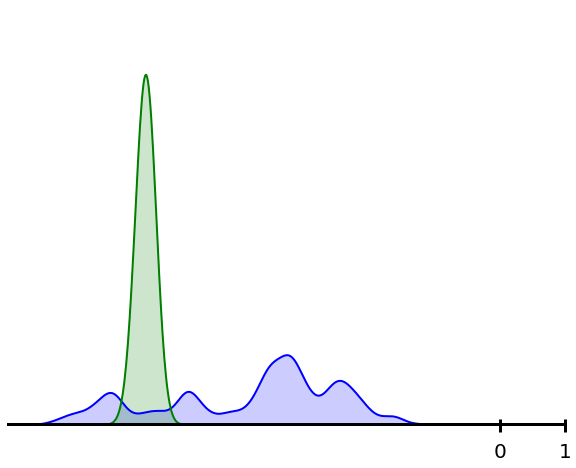

3IDP_lig 3PPK_lig


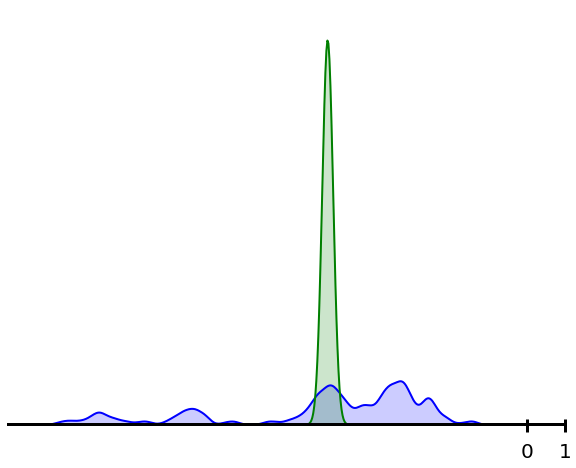

3IDP_lig 3PRF_lig
3IDP_lig 3PRI_lig
3IDP_lig 3PSB_lig


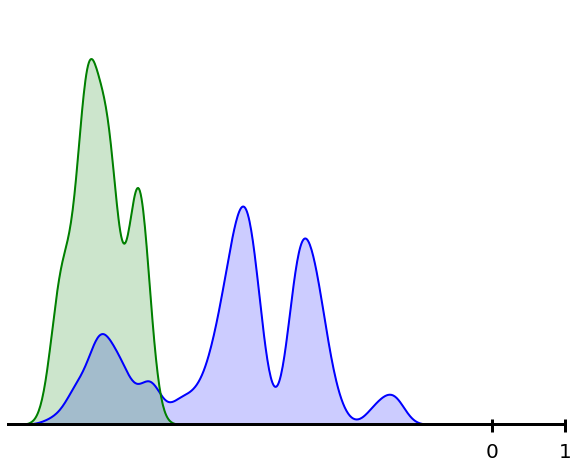

3IDP_lig 3PSD_lig
3IDP_lig 3Q4C_lig
3IDP_lig 3Q96_lig
3IDP_lig 3SKC_lig
3IDP_lig 3TV4_lig
3IDP_lig 3TV6_lig
3IDP_lig 4DBN_lig
3IDP_lig 4E26_lig
error
3IDP_lig 4E4X_lig
3IDP_lig 4EHE_lig
3IDP_lig 4EHG_lig
3IDP_lig 4FC0_lig


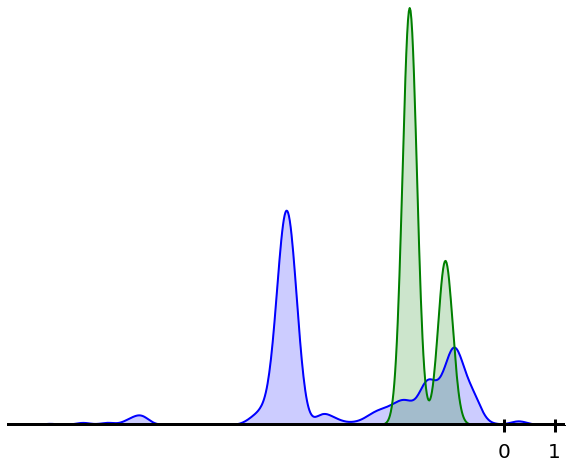

3IDP_lig 4G9C_lig
3IDP_lig 4G9R_lig


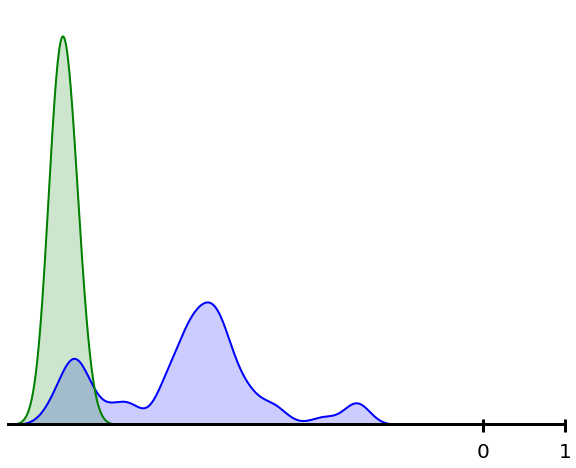

3II5_lig 3PPJ_lig
3II5_lig 3PPK_lig
3II5_lig 3PRF_lig
3II5_lig 3PRI_lig
3II5_lig 3PSB_lig
3II5_lig 3PSD_lig
3II5_lig 3Q4C_lig
3II5_lig 3Q96_lig
error
3II5_lig 3SKC_lig
3II5_lig 3TV4_lig
3II5_lig 3TV6_lig
3II5_lig 4DBN_lig
error
3II5_lig 4E26_lig
3II5_lig 4E4X_lig
3II5_lig 4EHE_lig
3II5_lig 4EHG_lig
3II5_lig 4FC0_lig
error
3II5_lig 4G9C_lig
error
3II5_lig 4G9R_lig
error
3PPJ_lig 3PPK_lig


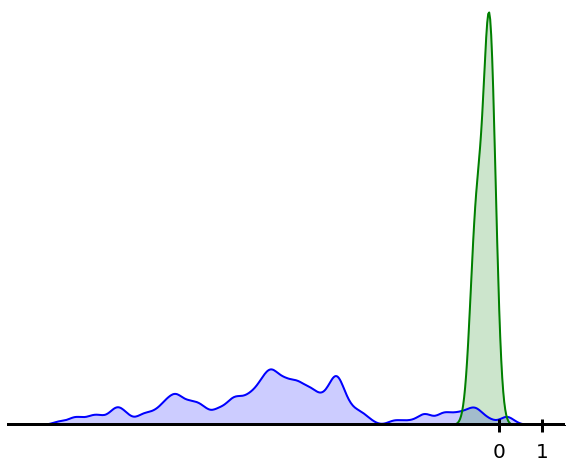

3PPJ_lig 3PRF_lig


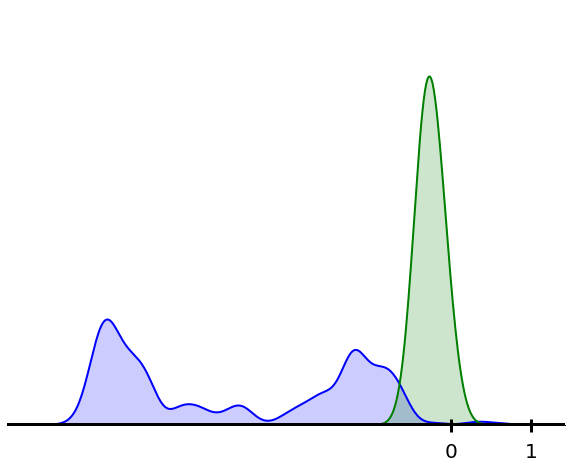

3PPJ_lig 3PRI_lig
error
3PPJ_lig 3PSB_lig


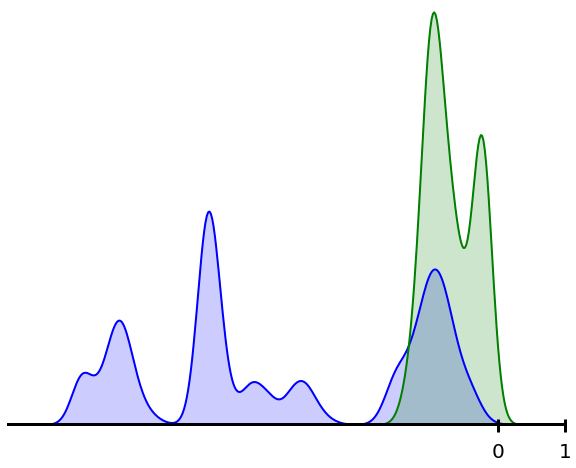

3PPJ_lig 3PSD_lig
3PPJ_lig 3Q4C_lig
3PPJ_lig 3Q96_lig
3PPJ_lig 3SKC_lig
3PPJ_lig 3TV4_lig
3PPJ_lig 3TV6_lig
3PPJ_lig 4DBN_lig
3PPJ_lig 4E26_lig
3PPJ_lig 4E4X_lig
3PPJ_lig 4EHE_lig
3PPJ_lig 4EHG_lig
3PPJ_lig 4FC0_lig
3PPJ_lig 4G9C_lig
3PPJ_lig 4G9R_lig
3PPK_lig 3PRF_lig


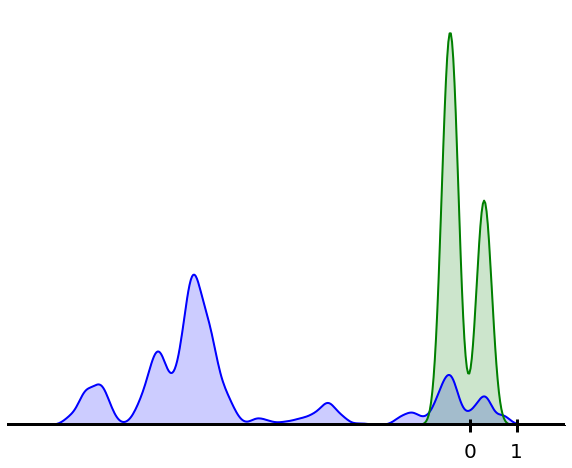

3PPK_lig 3PRI_lig
error
3PPK_lig 3PSB_lig
3PPK_lig 3PSD_lig
3PPK_lig 3Q4C_lig
3PPK_lig 3Q96_lig
3PPK_lig 3SKC_lig
3PPK_lig 3TV4_lig
3PPK_lig 3TV6_lig
3PPK_lig 4DBN_lig
3PPK_lig 4E26_lig
error
3PPK_lig 4E4X_lig
3PPK_lig 4EHE_lig
3PPK_lig 4EHG_lig
3PPK_lig 4FC0_lig
3PPK_lig 4G9C_lig
3PPK_lig 4G9R_lig
3PRF_lig 3PRI_lig
error
3PRF_lig 3PSB_lig
3PRF_lig 3PSD_lig
3PRF_lig 3Q4C_lig
3PRF_lig 3Q96_lig
3PRF_lig 3SKC_lig
3PRF_lig 3TV4_lig
3PRF_lig 3TV6_lig
3PRF_lig 4DBN_lig
3PRF_lig 4E26_lig
3PRF_lig 4E4X_lig
3PRF_lig 4EHE_lig
3PRF_lig 4EHG_lig
3PRF_lig 4FC0_lig
3PRF_lig 4G9C_lig
3PRF_lig 4G9R_lig
3PRI_lig 3PSB_lig
3PRI_lig 3PSD_lig
3PRI_lig 3Q4C_lig
3PRI_lig 3Q96_lig
3PRI_lig 3SKC_lig
3PRI_lig 3TV4_lig
3PRI_lig 3TV6_lig
3PRI_lig 4DBN_lig
3PRI_lig 4E26_lig
3PRI_lig 4E4X_lig
3PRI_lig 4EHE_lig
3PRI_lig 4EHG_lig
3PRI_lig 4FC0_lig
3PRI_lig 4G9C_lig
3PRI_lig 4G9R_lig
3PSB_lig 3PSD_lig
3PSB_lig 3Q4C_lig
3PSB_lig 3Q96_lig
3PSB_lig 3SKC_lig
3PSB_lig 3TV4_lig
3PSB_lig 3TV6_lig
3PSB_lig 4DBN_lig
3PSB_lig 4

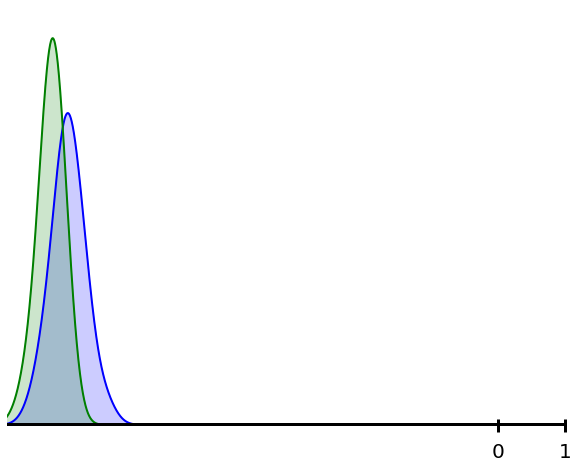

3Q96_lig 4G9R_lig


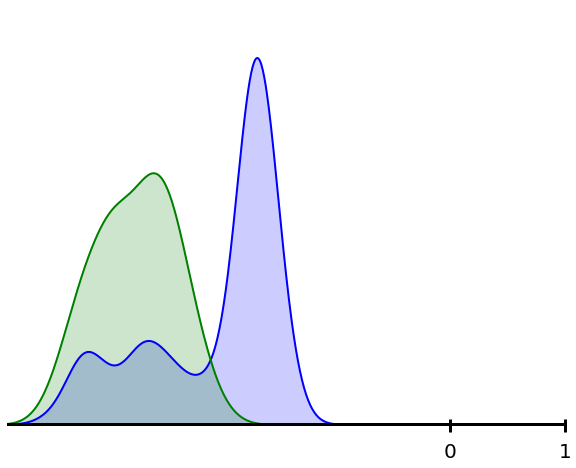

3SKC_lig 3TV4_lig
error
3SKC_lig 3TV6_lig
error
3SKC_lig 4DBN_lig
3SKC_lig 4E26_lig
3SKC_lig 4E4X_lig
error
3SKC_lig 4EHE_lig
error
3SKC_lig 4EHG_lig
error
3SKC_lig 4FC0_lig
3SKC_lig 4G9C_lig
error
3SKC_lig 4G9R_lig
3TV4_lig 3TV6_lig


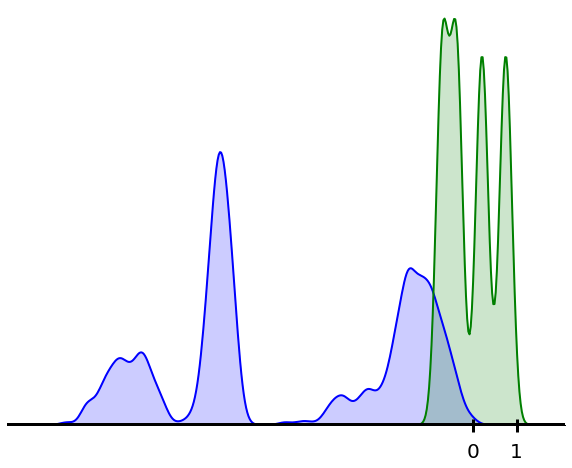

3TV4_lig 4DBN_lig
3TV4_lig 4E26_lig
3TV4_lig 4E4X_lig
error
3TV4_lig 4EHE_lig


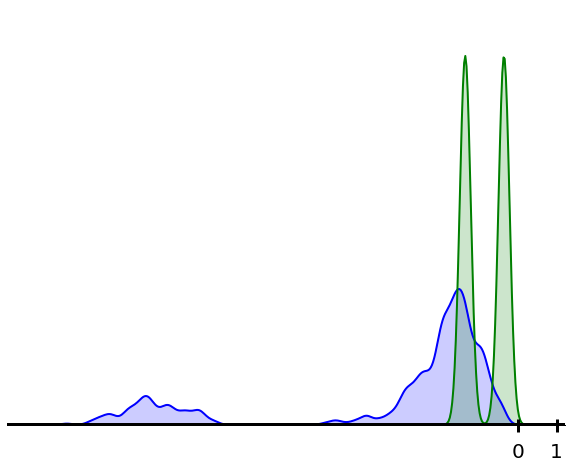

3TV4_lig 4EHG_lig
error
3TV4_lig 4FC0_lig
3TV4_lig 4G9C_lig


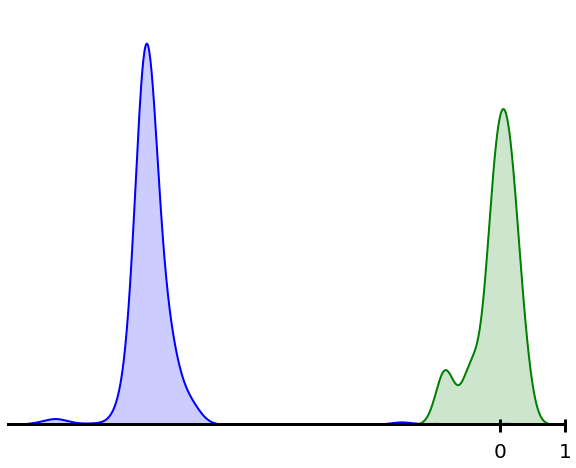

3TV4_lig 4G9R_lig
3TV6_lig 4DBN_lig
3TV6_lig 4E26_lig
3TV6_lig 4E4X_lig
error
3TV6_lig 4EHE_lig


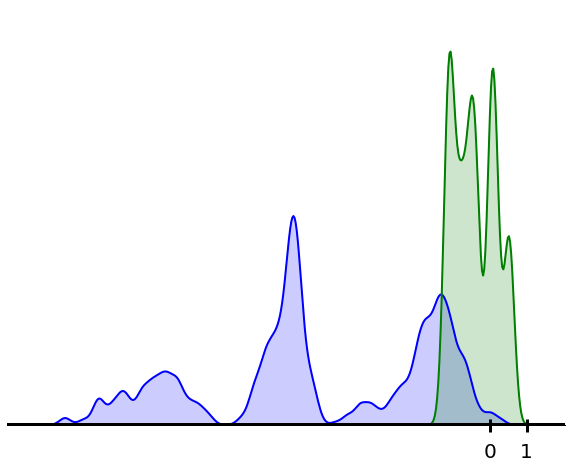

3TV6_lig 4EHG_lig
error
3TV6_lig 4FC0_lig
3TV6_lig 4G9C_lig


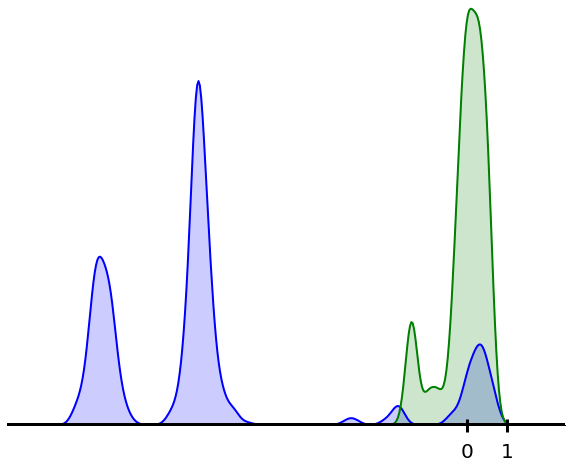

3TV6_lig 4G9R_lig
4DBN_lig 4E26_lig
4DBN_lig 4E4X_lig
4DBN_lig 4EHE_lig


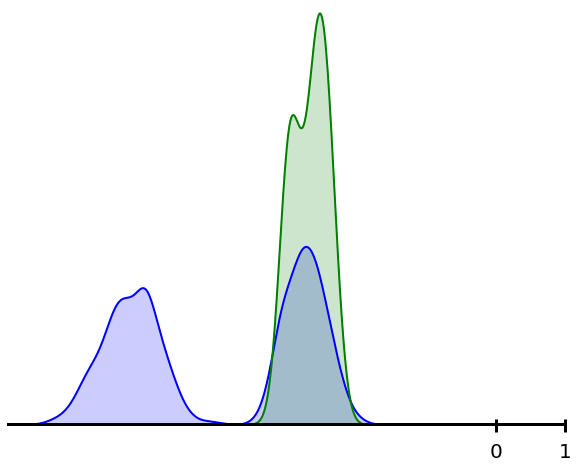

4DBN_lig 4EHG_lig
error
4DBN_lig 4FC0_lig


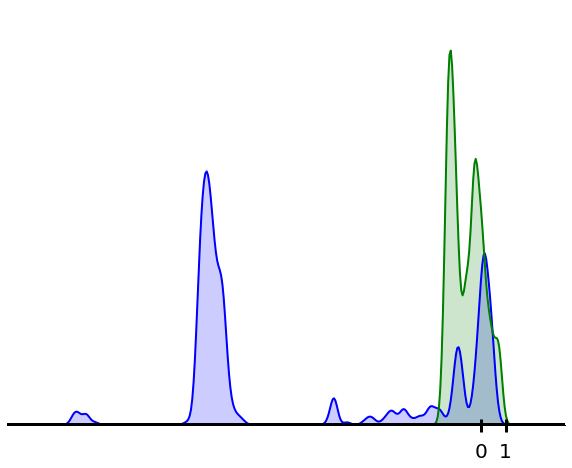

4DBN_lig 4G9C_lig
4DBN_lig 4G9R_lig
4E26_lig 4E4X_lig
4E26_lig 4EHE_lig
4E26_lig 4EHG_lig
4E26_lig 4FC0_lig
4E26_lig 4G9C_lig
4E26_lig 4G9R_lig
4E4X_lig 4EHE_lig
error
4E4X_lig 4EHG_lig
error
4E4X_lig 4FC0_lig
4E4X_lig 4G9C_lig
4E4X_lig 4G9R_lig
4EHE_lig 4EHG_lig
error
4EHE_lig 4FC0_lig


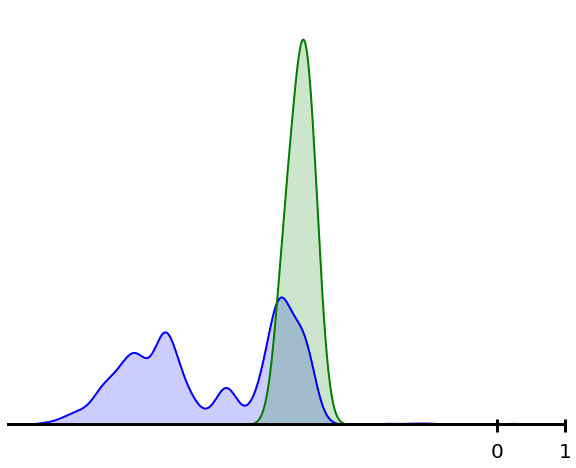

4EHE_lig 4G9C_lig


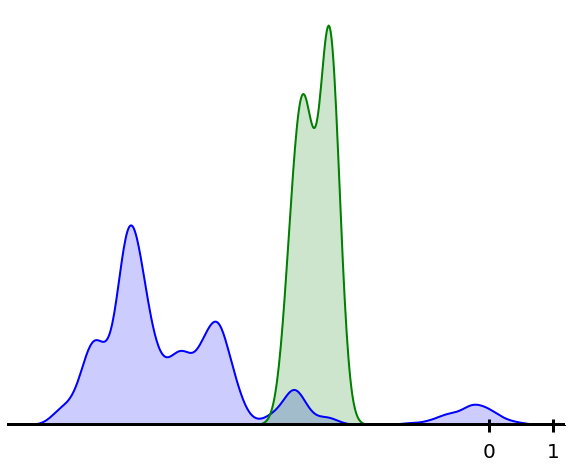

4EHE_lig 4G9R_lig


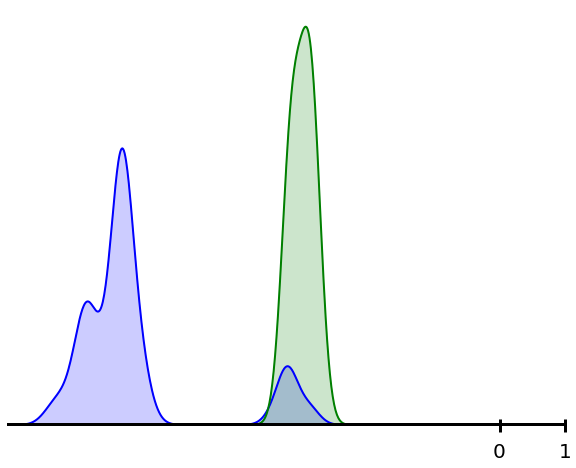

4EHG_lig 4FC0_lig
error
4EHG_lig 4G9C_lig
error
4EHG_lig 4G9R_lig
error
4FC0_lig 4G9C_lig


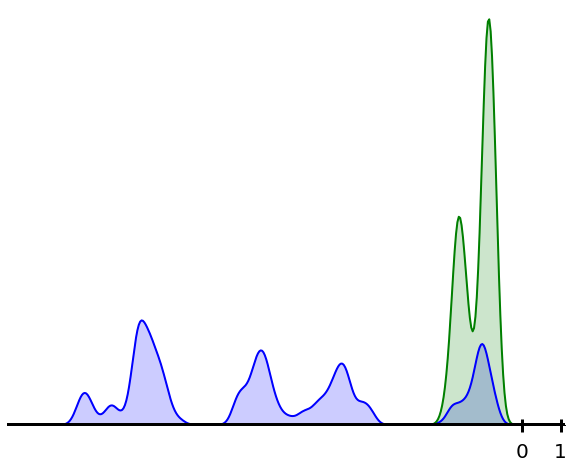

4FC0_lig 4G9R_lig


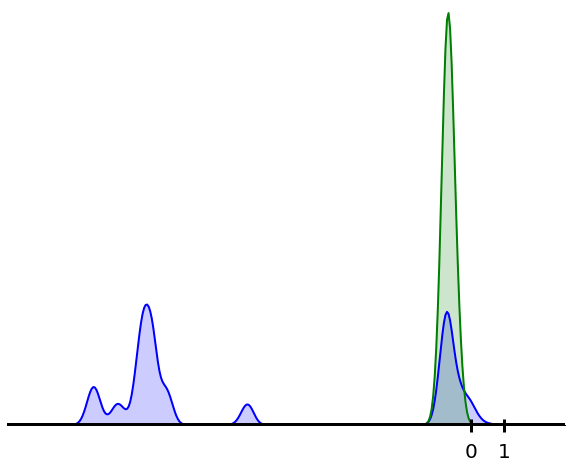

4G9C_lig 4G9R_lig


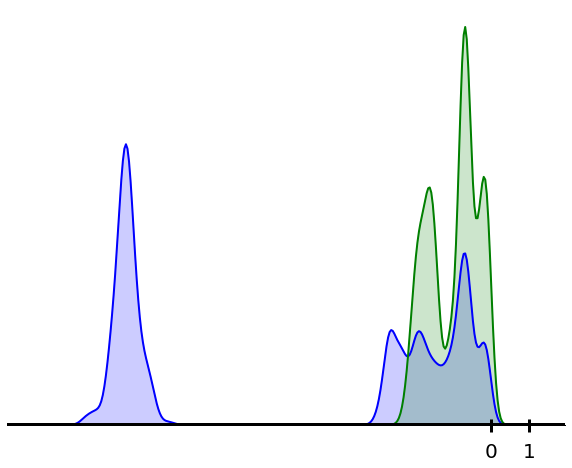

In [7]:
for f_name in ['mcss']:#features.keys():
    print f_name#, stats.evidence.std[f_name]
    stats.show_stats(f_name, raw=False, smoothed=True)
    try:
        stats.show_stats_by_pair(f_name, raw=False, smoothed=True)
    except:
        print 'ugh'
        continue

In [ ]:
num_poses = 100
t = 100

for s, st in all_data.proteins[p].docking.items():

    print p, s

    l_list = sorted(st.ligands.keys())[:10]

    ps = PredictStructs(st, stats.evidence, features, num_poses, t)
    best_cluster, en_landscape = ps.max_posterior(l_list, verbose=True, sampling=1, en_landscape=True)

    #ps2 = PredictStructs(st, stats.evidence, {}, num_poses, t)
    #best_cluster2, en_landscape2 = ps2.max_posterior(l_list, verbose=False, sampling=1, en_landscape=True)

    us_top = ps.ligset.get_poses(best_cluster)
    glide_top = ps.ligset.get_poses({l:0 for l in best_cluster})
    
    for l in l_list:
        print l, us_top[l].rank, us_top[l].rmsd, 0, glide_top[l].rmsd
    print 'us rmsd:',np.mean([po.rmsd for l,po in us_top.items()])
    print 'phys rmsd:',np.mean([po.rmsd for l,po in glide_top.items()])

In [ ]:
# show energy landscape (score vs rmsd)

norm1 = max([x[0] for x in en_landscape])
objective = [x[0]/norm1 for x in en_landscape]
rmsds = [x[1] for x in en_landscape]
plt.plot(rmsds, objective, 'r.')

norm2 = max([x[0] for x in en_landscape2])
phys_obj = [x[0]/norm2 for x in en_landscape2]
rmsds2 = [x[1] for x in en_landscape2]
plt.plot(rmsds2, phys_obj, 'k.')

#plt.ylim([-1600,-700])
#plt.ylim([0.99,1.05])
plt.show()

In [ ]:
all_data.assign_weights({2:1,3:1,4:1,6:1,11:0.005})

show_side_by_side(us_top, glide_top, l_list, 
                  t1='Our Top Poses', t2='Glide Top Poses', num_i=10, size=1.5)

In [ ]:
show_prob = True
show_x = True

for k,kdef in features.items():
    x1, log_p1 = ps.x(best_cluster,k,kdef,lig_order=l_list)
    x2, log_p2 = ps.x({l:0 for l in l_list},k,kdef,lig_order=l_list)
    
    if show_prob and np.sum(log_p1) != 0:
        print k, 'probability matrix'
        minval = min(np.min(log_p1[np.nonzero(log_p1)]),np.min(log_p2[np.nonzero(log_p2)]))
        maxval = max(np.max(log_p1[np.nonzero(log_p1)]),np.max(log_p2[np.nonzero(log_p2)]))
        
        show_features(us_top, log_p1, glide_top, log_p2, l_list, 'us top','glide top',size=1.5,mi=minval,ma=maxval)
        
    if show_x:
        print k, 'x_k matrix'
        minval = min(np.min(x1),np.min(x2))
        maxval = max(np.max(x1),np.max(x2))
    
        show_features(us_top, x1, glide_top, x2, l_list, 'us top','glide top',size=1.5,mi=minval,ma=maxval)